# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


Очевидно лик в данных это признак "salary", поэтому удалим его сначала, а потом выделим таргет + разделим выборку (так как это тоже самое что и наш таргет считай, только в другой валюте по всей видимости)

In [ ]:
from sklearn.model_selection import train_test_split

# -- YOUR CODE HERE --
df = df.drop("salary", axis=1)
y = df['salary_in_usd']
X = df.drop("salary_in_usd", axis=1)

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=45)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=45)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
X.head()

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,EUR,ES,100,ES,L
1,2023,MI,CT,ML Engineer,USD,US,100,US,S
2,2023,MI,CT,ML Engineer,USD,US,100,US,S
3,2023,SE,FT,Data Scientist,USD,CA,100,CA,M
4,2023,SE,FT,Data Scientist,USD,CA,100,CA,M


In [ ]:
X.dtypes[X.dtypes != "int64"].index

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import sqrt

categorical_features = list(X.dtypes[X.dtypes != "int64"].index)
numeric_features = list(X.dtypes[X.dtypes == "int64"].index)

column_trans = ColumnTransformer(
    transformers=[
        ('O_H_E', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough'
)

pipeline_lg = Pipeline(steps=[('column_trans', column_trans), ('linear_regressor', LinearRegression())])

pipeline_lg.fit(X_train, y_train)

y_pred = pipeline_lg.predict(X_val)

print('MAPE: ', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE: ', sqrt(mean_squared_error(y_val, y_pred)))

MAPE:  0.35363255958807904
RMSE:  45751.48257491075


Будем замерять время, чтобы потом сравнивать сколько модели обучались

In [ ]:
import time

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
?XGBRegressor

In [ ]:
?GridSearchCV

In [ ]:
pipeline_xgb = Pipeline(steps=[('column_trans', column_trans), ('xgb_regressor', XGBRegressor())])

In [ ]:
params = {
    'xgb_regressor__max_depth' : [None, 1, 2, 8, 16, 40],
    'xgb_regressor__learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'xgb_regressor__n_estimators' : [20, 40, 80, 120, 200],
    'xgb_regressor__gamma' : [0, 0.1, 0.2],
    # -- YOUR CODE HERE --
}

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=params,
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Лучшие параметры: {'xgb_regressor__gamma': 0, 'xgb_regressor__learning_rate': 0.2, 'xgb_regressor__max_depth': 2, 'xgb_regressor__n_estimators': 200}


In [ ]:
# -- YOUR CODE HERE --
pipeline_xgb_best = Pipeline(steps=[('column_trans', column_trans),
 ('xgb_regressor', XGBRegressor(n_estimators=200, max_depth=2, learning_rate=0.2, gamma=0))])

start_t = time.time()
pipeline_xgb_best.fit(X_train, y_train)
end_t = time.time()
train_t = end_t - start_t

start_t = time.time()
y_pred = pipeline_xgb_best.predict(X_val)
end_t = time.time()
pred_t = end_t - start_t

print('MAPE: ', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE: ', sqrt(mean_squared_error(y_val, y_pred)))
print('Training time:', train_t, 's')
print('Prediction time:', pred_t, 's')

MAPE:  0.3309611678123474
RMSE:  46052.99208520549
Training time: 0.53818678855896 s
Prediction time: 0.02118515968322754 s


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
!pip3 install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
?CatBoostRegressor

In [ ]:
pipeline_cb = Pipeline(steps=[('column_trans', column_trans), ('catboost', CatBoostRegressor())])

In [ ]:
params = {
    'catboost__depth' : [None, 1, 2, 8, 16, 40],
    'catboost__learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'catboost__iterations' : [20, 40, 80, 120, 200]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline_cb,
    param_grid=params,
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 61271.1808176	total: 4.11ms	remaining: 160ms
1:	learn: 59487.5805703	total: 27.1ms	remaining: 515ms
2:	learn: 57967.9629516	total: 49.5ms	remaining: 611ms
3:	learn: 56566.0214562	total: 139ms	remaining: 1.25s
4:	learn: 55433.2756909	total: 162ms	remaining: 1.14s
5:	learn: 54419.3796708	total: 246ms	remaining: 1.39s
6:	learn: 53471.2924411	total: 588ms	remaining: 2.77s
7:	learn: 52716.2634706	total: 595ms	remaining: 2.38s
8:	learn: 52080.5049681	total: 951ms	remaining: 3.27s
9:	learn: 51447.2652618	total: 1.29s	remaining: 3.89s
10:	learn: 50947.1165613	total: 1.34s	remaining: 3.54s
11:	learn: 50401.5322748	total: 1.67s	remaining: 3.91s
12:	learn: 49933.6765980	total: 1.76s	remaining: 3.65s
13:	learn: 49658.9322858	total: 1.76s	remaining: 3.27s
14:	learn: 49313.4747862	total: 1.79s	remaining: 2.98s
15:	learn: 49093.6015373	total: 1.79s	remaining: 2.68s
16:	learn: 48761.6946463	total: 1.98s	remaining: 2.67s
17:	

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

0:	learn: 59535.0173039	total: 3.66ms	remaining: 435ms
1:	learn: 56717.1289104	total: 7.21ms	remaining: 425ms
2:	learn: 54897.3379550	total: 8.95ms	remaining: 349ms
3:	learn: 53384.2789585	total: 10.6ms	remaining: 306ms
4:	learn: 52185.3061883	total: 12.1ms	remaining: 277ms
5:	learn: 51323.6967724	total: 13.6ms	remaining: 259ms
6:	learn: 50690.5157884	total: 15.3ms	remaining: 248ms
7:	learn: 50299.3346070	total: 16.9ms	remaining: 236ms
8:	learn: 49899.9733621	total: 18.5ms	remaining: 228ms
9:	learn: 49618.7401092	total: 20.1ms	remaining: 221ms
10:	learn: 49350.0432080	total: 21.7ms	remaining: 215ms
11:	learn: 49169.7828217	total: 23.1ms	remaining: 208ms
12:	learn: 49038.2486817	total: 24.7ms	remaining: 204ms
13:	learn: 48825.4642480	total: 26.2ms	remaining: 198ms
14:	learn: 48778.7921813	total: 27.7ms	remaining: 194ms
15:	learn: 48648.8780547	total: 29.2ms	remaining: 190ms
16:	learn: 48529.4423882	total: 33ms	remaining: 200ms
17:	learn: 48483.6002793	total: 34.6ms	remaining: 196ms
18:	

In [ ]:
pipeline_catboost_best = Pipeline(steps=[('column_trans', column_trans),
 ('catboost', CatBoostRegressor(depth=None, iterations=120, learning_rate=0.2))])

start_t = time.time()
pipeline_catboost_best.fit(X_train, y_train)
end_t = time.time()
train_t = end_t - start_t

start_t = time.time()
y_pred = pipeline_catboost_best.predict(X_val)
end_t = time.time()
pred_t = end_t - start_t

print('MAPE: ', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE: ', sqrt(mean_squared_error(y_val, y_pred)))
print('Training time:', train_t, 's')
print('Prediction time:', pred_t, 's')

0:	learn: 59535.0173039	total: 9.72ms	remaining: 1.16s
1:	learn: 56717.1289104	total: 16.8ms	remaining: 988ms
2:	learn: 54897.3379550	total: 28.4ms	remaining: 1.11s
3:	learn: 53384.2789585	total: 30.4ms	remaining: 883ms
4:	learn: 52185.3061883	total: 47.3ms	remaining: 1.09s
5:	learn: 51323.6967724	total: 49.5ms	remaining: 941ms
6:	learn: 50690.5157884	total: 59.4ms	remaining: 958ms
7:	learn: 50299.3346070	total: 61.4ms	remaining: 860ms
8:	learn: 49899.9733621	total: 63.2ms	remaining: 780ms
9:	learn: 49618.7401092	total: 75.5ms	remaining: 831ms
10:	learn: 49350.0432080	total: 77.6ms	remaining: 769ms
11:	learn: 49169.7828217	total: 88ms	remaining: 792ms
12:	learn: 49038.2486817	total: 91.4ms	remaining: 752ms
13:	learn: 48825.4642480	total: 101ms	remaining: 762ms
14:	learn: 48778.7921813	total: 108ms	remaining: 756ms
15:	learn: 48648.8780547	total: 115ms	remaining: 751ms
16:	learn: 48529.4423882	total: 123ms	remaining: 746ms
17:	learn: 48483.6002793	total: 130ms	remaining: 739ms
18:	learn

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool

cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_features]

X_train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
X_val_pool = Pool(X_val, y_val, cat_features=cat_features_indices)

In [ ]:
catboost_depth = [None, 1, 2, 8, 16]
catboost_learning_rate = [0.01, 0.05, 0.1, 0.2]
catboost_iterations = [20, 40, 80, 120, 200]

# так как greed search принимает именно numpy, pandas, то приходится вручную
best_score = float('inf')
best_RMSE = None
MAPE_for_best = None
time_train_for_best = None
time_pred_for_best = None

for depth in catboost_depth:
    for learning_rate in catboost_learning_rate:
        for iterations in catboost_iterations:

          cb_tmp = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, verbose=False)

          start_t = time.time()
          cb_tmp.fit(X_train_pool)
          end_t = time.time()
          train_t = end_t - start_t

          start_t = time.time()
          y_pred = cb_tmp.predict(X_val_pool)
          end_t = time.time()
          pred_t = end_t - start_t

          if sqrt(mean_squared_error(y_val, y_pred)) < best_score:
              best_score = sqrt(mean_squared_error(y_val, y_pred))
              MAPE_for_best = mean_absolute_percentage_error(y_val, y_pred)
              time_train_for_best = train_t
              time_pred_for_best = pred_t

print('Best RMSE:', best_score)
print('MAPE: ', MAPE_for_best)
print('Training time:', time_train_for_best, 's')
print('Prediction time:', time_pred_for_best, 's')

Best RMSE: 45701.33421327186
MAPE:  0.3616518723569826
Training time: 2.4462153911590576 s
Prediction time: 0.0012214183807373047 s


**Ответ:** лучше не стало(((

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
pipeline_lgmb = Pipeline(steps=[('column_trans', column_trans), ('lgbm_regressor', LGBMRegressor())])

params = {
    'lgbm_regressor__depth' : [None, 1, 2, 8, 16, 40],
    'lgbm_regressor__learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'lgbm_regressor__iterations' : [20, 40, 80, 120, 200]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline_lgmb,
    param_grid=params,
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] U

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] U

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 38
[LightGBM] [Info] Start training from score 137726.978532
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 37
[LightGBM] [Info] Start training from score 138466.625874
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 34
[LightGBM] [Info] Start training from score 137686.216176
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds

In [ ]:
pipeline_lgmb_best = Pipeline(steps=[('column_trans', column_trans),
 ('lgbm_regressor', LGBMRegressor(depth=None, iterations=20, learning_rate=0.05))])

start_t = time.time()
pipeline_lgmb_best.fit(X_train, y_train)
end_t = time.time()
train_t = end_t - start_t

start_t = time.time()
y_pred = pipeline_lgmb_best.predict(X_val)
end_t = time.time()
pred_t = end_t - start_t

print('MAPE: ', mean_absolute_percentage_error(y_val, y_pred))
print('RMSE: ', sqrt(mean_squared_error(y_val, y_pred)))
print('Training time:', train_t, 's')
print('Prediction time:', pred_t, 's')

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137959.855859
[LightGBM] [Warning] Unknown parameter: iterations
MAPE:  0.3399975341335615
RMSE:  47270.680123937345
Training time: 0.09006333351135254 s
Prediction time: 0.012859582901000977 s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

## Сравнение моделей бустинга

| Модель     | Лучшие параметры                                                                 | MAPE       | RMSE       | Время обучения (с) | Время предсказания (с) |
|------------|----------------------------------------------------------------------------------|------------|------------|---------------------|------------------------|
| **XGBoost**  | `gamma=0`, `learning_rate=0.2`, `max_depth=2`, `n_estimators=200`               | 0.3310     | 46053.0    | 0.538               | 0.021                  |
| **CatBoost** | `depth=None`, `iterations=120`, `learning_rate=0.2`                             | **0.3260** | **45179.2**| 1.473               | 0.049                  |
| **LightGBM** | `depth=None`, `iterations=20`, `learning_rate=0.05`                             | 0.3400     | 47270.7    | **0.090**           | **0.013**              |

По таблице можно заметить, что **лучшее качество** у **CatBoost** (MAPE=0.326, RMSE=45179.2), **по быстроте обучения и предсказания** выигрывает **LightGBM** (обучение: 0.09с, предсказание: 0.013с), а **баланс** между тем и тем поддерживает **XGBoost** (средние показатели по всем метрикам).

### Интересные отличия в параметрах

Модели XGBoost и CatBoost требуют высокое количество estimatirs, а также достаточно высокие learning_rate, в отличии от LightGBM (возможно поэтому он быстро обучался и предсказывал). Также модель XGBoost предпочитает маленькую глубину, что не скажешь про ее конкурентов.

### Вывод

Тем не менее, модели не далеко ушли по ошибкам, но все равно в сравнении заметно, какая качественнее, а какая быстрее при обучении. Таким образом, под разные задачи можно использовать разные модели, в зависимости от того, что вам важнее в текущей задаче.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [2]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители. Выкиньте строку под названием `user`.

In [3]:
# -- YOUR CODE HERE --
ratings = ratings.drop("user", axis=1)
ratings.head()

,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,kanye west,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,0.012738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,0.095220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ratings_tmp = ratings

In [5]:
ratings = ratings.T
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [6]:
# -- YOUR CODE HERE --
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
alison krauss & union station,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

k_means = KMeans(n_clusters = 5)
k_means = k_means.fit(ratings)
clusters = k_means.predict(ratings)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
# -- YOUR CODE HERE --
Counter(clusters)

Counter({np.int32(3): 1,
         np.int32(0): 996,
         np.int32(2): 1,
         np.int32(4): 1,
         np.int32(1): 1})

**Ответ:** Несложно заметить, какие наравномерные получились кластеры, один из них (1) содержит 99% от всех исполнителей. Я предполагаю, что связано это с тем, что у нас очень много признаков и очень много при этом 0 на месте данных, в силу чего если делать всего 5 кластеров, то большинство из исполнителей будут похожи друг на друга (хотя их потенциально можно было бы разделить на большее количество кластеров)

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
# -- YOUR CODE HERE --
print(ratings.index[np.where(clusters == 0)[0][0]])
print(ratings.index[np.where(clusters == 1)[0][0]])
print(ratings.index[np.where(clusters == 2)[0][0]])
print(ratings.index[np.where(clusters == 3)[0][0]])
print(ratings.index[np.where(clusters == 4)[0][0]])

radiohead
mötley crüe
bruce springsteen
the beatles
atmosphere


Действительно, под кластером №3 есть the beatles.

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
# -- YOUR CODE HERE --
listeners_fraction = []
for i in range(len(ratings)):
  singer = ratings.iloc[i]
  listeners_fraction.append(len(singer[singer > 0]) / float(len(singer)))
  if ratings.index[i] == "the beatles":
    print(f"Доля the beatles: {len(singer[singer > 0]) / float(len(singer))}")

listeners_fraction.sort(reverse=True)
print(f"Самые огромные доли пользователей по прослушиваниям исполнителей:", listeners_fraction[:5])

Доля the beatles: 0.3342
Самые огромные доли пользователей по прослушиваниям исполнителей: [0.3342, 0.2778, 0.1862, 0.1682, 0.1628]


**Ответ:**  Ага! Мы обнаружили, что группу the beatles слушают больше всего! Я думаю, это происходит по причине того, что ее слушает очень много людей, из-за чего она становится отличительной (вектор прослушивания отличается от всех) и поэтому кластер для нее выделяется отдельный.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [7]:
from sklearn.preprocessing import normalize

ratings_norm = normalize(ratings, axis=1)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
k_means = KMeans(n_clusters = 5)
k_means = k_means.fit(ratings_norm)
clusters = k_means.predict(ratings_norm)
Counter(clusters)

Counter({np.int32(3): 383,
         np.int32(1): 213,
         np.int32(4): 217,
         np.int32(0): 70,
         np.int32(2): 117})

**Ответ** да, кластеризация стала лучше, теперь кластеры более сбалансированы относительно размеров. Теперь k_means не берет в счет популярность испольнителей, что полезнее для нашей задачи

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine


centroids = k_means.cluster_centers_

listeners_fraction = []
for j in range(len(centroids)):
  clust_indices = np.where(clusters == j)[0]
  clust_singers = ratings.index[clust_indices]
  clust_data = ratings_norm[clust_indices]

  distances = []
  for i, singer_data in enumerate(clust_data):
    distances.append((cosine(singer_data, centroids[j]), clust_singers[i]))
  distances.sort()

  print(f"Кластер {j}:")
  print("Топ-10 исполнителей этого кластера:")
  for dist, singer in distances[:10]:
      print(f"{singer}")
  print()

Кластер 0:
Топ-10 исполнителей этого кластера:
animal collective
broken social scene
sigur rós
explosions in the sky
grizzly bear
beirut
mogwai
m83
do make say think
black moth super rainbow

Кластер 1:
Топ-10 исполнителей этого кластера:
kelly clarkson
coldplay
maroon5
john mayer
nickelback
‌linkin park
evanescense
the killers
the fray
lifehouse

Кластер 2:
Топ-10 исполнителей этого кластера:
brand new
fall out boy
blink-182
new found glory
taking back sunday
saosin
cartel
chiodos
the starting line
all time low

Кластер 3:
Топ-10 исполнителей этого кластера:
radiohead
the beatles
the shins
belle and sebastian
the arcade fire
the pixies
sufjan stevens
velvet underground
spoon
dylan. bob

Кластер 4:
Топ-10 исполнителей этого кластера:
nas
jay-z
kanye west
a tribe called quest
the roots featuring d'angelo
lupe the gorilla
mos def
gangstarr
de la soul
metallica



**Ответ:** интерпретировать можно по жанрам музыки

Кластер 0 → Экспериментальная/пост-рок

Кластер 1 → Мейнстрим-рок 2000-х

Кластер 2 → Поп-панк/эмо

Кластер 3 → Инди-рок/классика

Кластер 4 → Хип-хоп

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

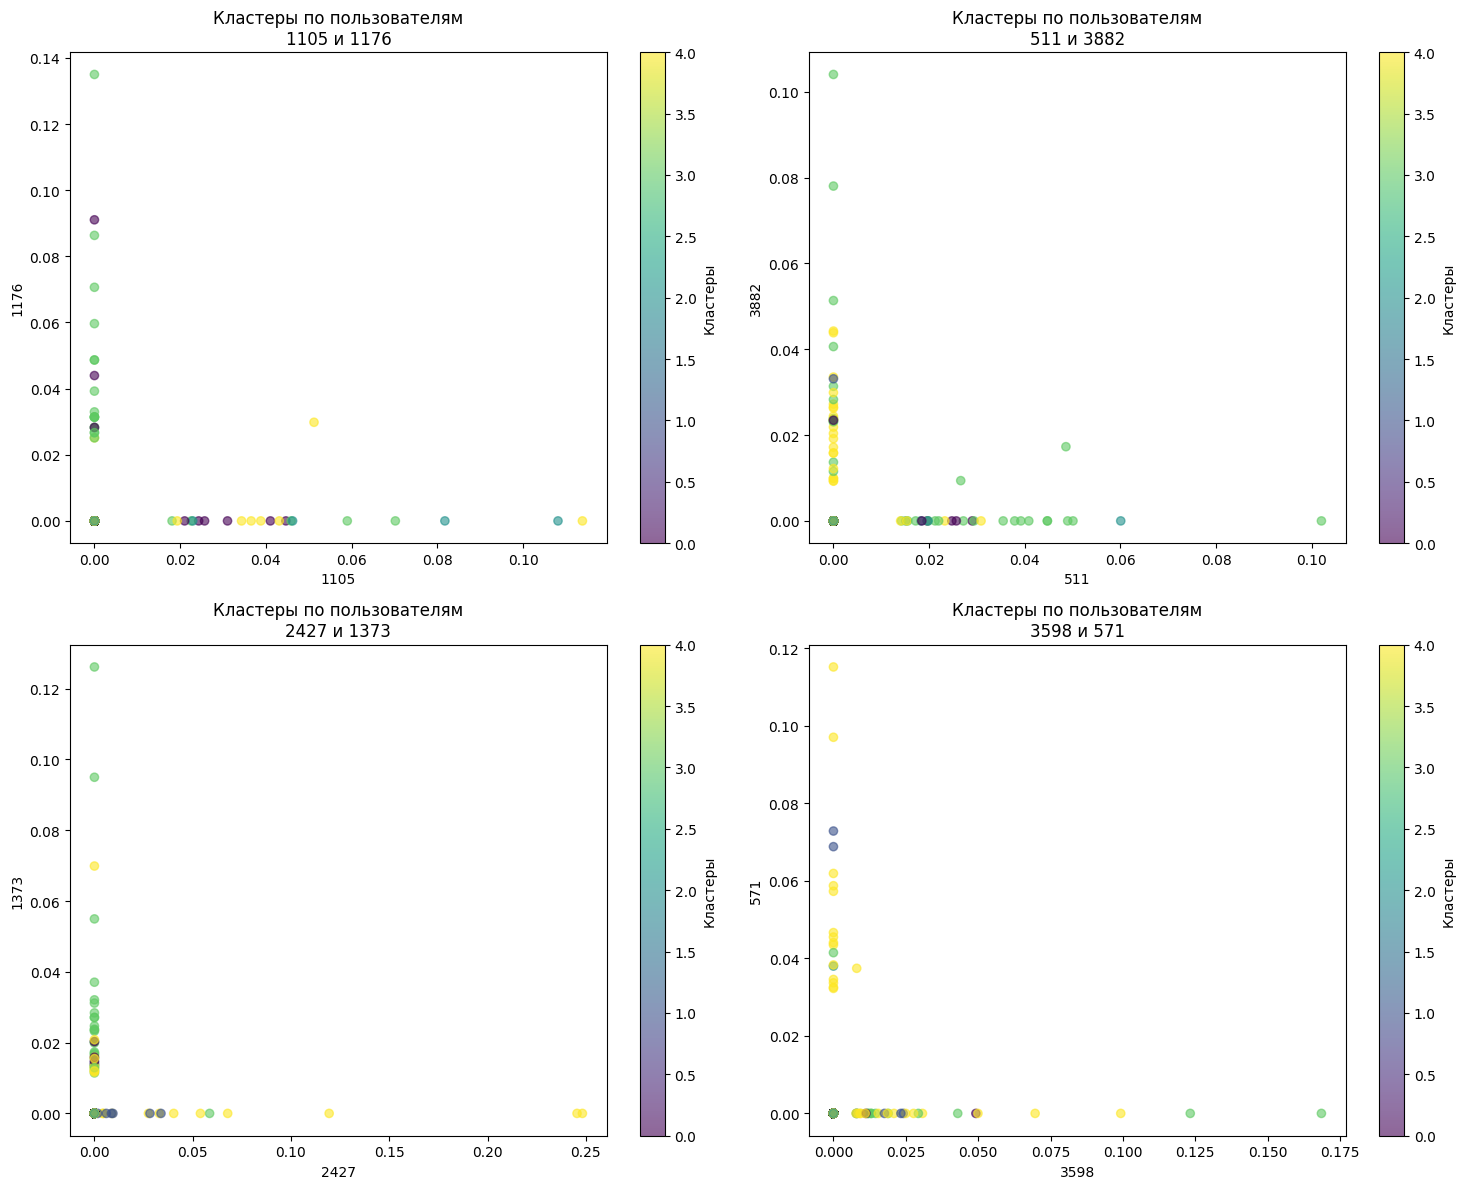

In [ ]:
import matplotlib.pyplot as plt

num_plots = 4
plt.figure(figsize=(15, 12))

# выбираем случайные пары признаков
random_pairs = np.random.choice(ratings.columns, size=(num_plots, 2), replace=False)

for i, (user1, user2) in enumerate(random_pairs):
    plt.subplot(2, 2, i+1)
    scatter = plt.scatter(ratings[user1], ratings[user2], c=clusters, alpha=0.6)
    plt.colorbar(scatter, label='Кластеры')
    plt.title(f'Кластеры по пользователям\n{user1} и {user2}')
    plt.xlabel(user1)
    plt.ylabel(user2)

plt.tight_layout()
plt.show()

**Ответ:** визуализации плохо отражают разделение, так как мы выбираем случайные признаки (пользователей), и тяжело судить исключительно по паре признаков (по паре пользователей), так как для обучения требуется большая размерность

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

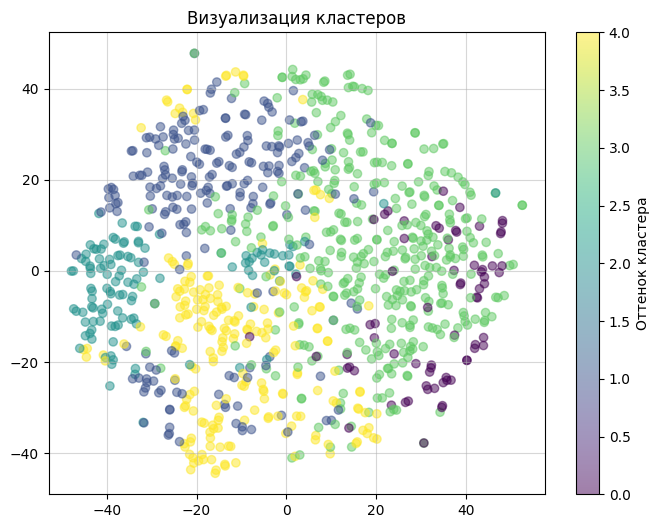

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
ratings_tsne = tsne.fit_transform(ratings_norm)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=clusters, alpha=0.5)
plt.colorbar(scatter, label='Оттенок кластера')
plt.title('Визуализация кластеров')
plt.grid(True, alpha=0.5)
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [10]:
from sklearn.metrics import silhouette_score

scores = []

for k in range(2, 101):
  kmeans_tmp = KMeans(n_clusters=k, random_state=42)
  clusters_temp = kmeans_tmp.fit_predict(ratings_norm)
  score = silhouette_score(ratings_norm, clusters_temp)
  scores.append(score)

NameError: name 'np' is not defined

In [11]:
import numpy as np

In [12]:
best_k = np.argmax(scores) + 2
best_score = max(scores)

print(f"Лучшее k: {best_k}")
print(f"Лучший результат: {best_score}")

Лучшее k: 98
Лучший результат: 0.01332710844154191


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [15]:
# -- YOUR CODE HERE --
from scipy.spatial.distance import cosine

kmeans_best = KMeans(n_clusters=best_k, random_state=42)
clusters_best = kmeans_best.fit_predict(ratings_norm)

centroids = kmeans_best.cluster_centers_

listeners_fraction = []
for j in range(len(centroids)):
  clust_indices = np.where(clusters_best == j)[0]
  clust_singers = ratings.index[clust_indices]
  clust_data = ratings_norm[clust_indices]

  distances = []
  for i, singer_data in enumerate(clust_data):
    distances.append((cosine(singer_data, centroids[j]), clust_singers[i]))
  distances.sort()

  print(f"Кластер {j}:")
  print("Топ-10 исполнителей этого кластера:")
  for dist, singer in distances[:10]:
      print(f"{singer}")
  print()

Кластер 0:
Топ-10 исполнителей этого кластера:
dr. dre
the faint
violent femmes
margot and the nuclear so and sos
owen
the bloodhound gang

Кластер 1:
Топ-10 исполнителей этого кластера:
john mayer
matt nathanson
gavin degraw
jason mraz
ray lamontagne
joshua radin
sara bareilles
augustana
maroon5
o.a.r.

Кластер 2:
Топ-10 исполнителей этого кластера:
white stripes
beck
the raconteurs
spoon
the pixies
the strokes
the flaming lips
cake
black rebel motorcycle club
gorillaz

Кластер 3:
Топ-10 исполнителей этого кластера:
fugazi
jawbreaker
sleater-kinney
les savy fav
capn jazz
bad brains
blonde redhead
propagandhi
the melvins
gogol bordello

Кластер 4:
Топ-10 исполнителей этого кластера:
ryan adams
band of horses
ryan adams and the cardinals
rogue wave
my morning jacket
matt pond pa
cloud cult
the american analog set
nada surf
tv on the radio

Кластер 5:
Топ-10 исполнителей этого кластера:
dj shadow
rjd2
amon tobin
jedi mind tricks
el-p
aphex twin
sublime
moby*
gnarls barkley
soul coughing


**Ответ:** получилось 98 кластеров, а не 5, более того, в некоторых кластерах меньше 10 испольнителей (не все топ 10 состоят из 10 штук). Таким образом, кластеризация стала более детальной по предпочтениям пользователей, артисты стали делиться по многожанровым категориям. Например, 9й кластер объединяет исполнителей, популярных среди аудитории 1980–1990-х годов, с уклоном в интеллектуальный рок, нью-вейв и софт-рок.



Сделайте t-SNE визуализацию полученной кластеризации.

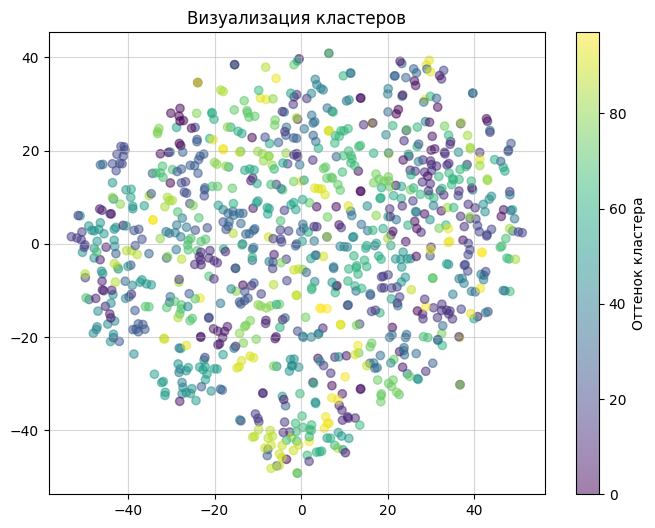

In [17]:
# -- YOUR CODE HERE --
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
ratings_tsne = tsne.fit_transform(ratings_norm)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=clusters_best, alpha=0.5)
plt.colorbar(scatter, label='Оттенок кластера')
plt.title('Визуализация кластеров')
plt.grid(True, alpha=0.5)
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

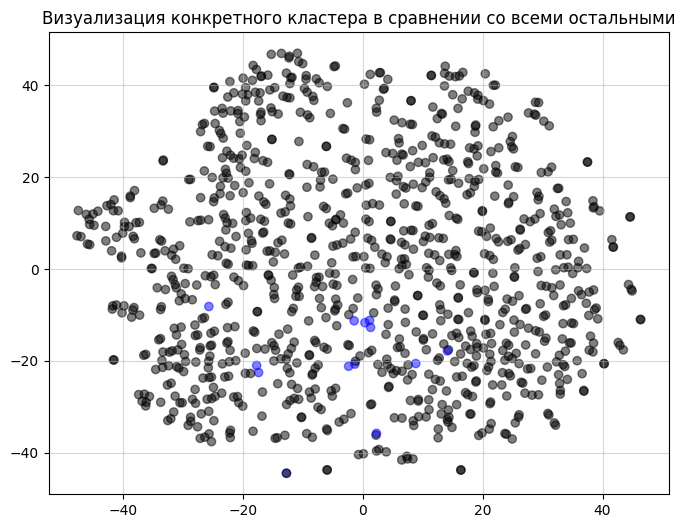

In [19]:
# -- YOUR CODE HERE --
tsne = TSNE(n_components=2)
ratings_tsne = tsne.fit_transform(ratings_norm)

some_clust = 56 # рандомное число
plt.figure(figsize=(8, 6))
colors = ['blue' if label == 56 else 'black' for label in clusters_best]
scatter = plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=colors, alpha=0.5)
plt.title('Визуализация конкретного кластера в сравнении со всеми остальными')
plt.grid(True, alpha=0.5)
plt.show()

**Ответ:** наш интересный кластер плохо отражается в t-SNE визуализации, так как точки разбросаны по плоскости. Из этого можно сделать вывод, что t-SNE не всегда обладает способностями перенести многомерную кластеризацию на двумерную.